In [133]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

## Questão 1

### Considere o conjunto de dados disponível em concrete.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353

In [134]:
dataset = np.genfromtxt('./concrete.csv', delimiter=',', skip_header=0)

#### a) Considere um modelo de regressão não linear baseado em redes neurais articiais. Separe os dados aleatoriamente em treino, validação e teste(por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:  

In [135]:
x_train, x_test_tmp, y_train, y_test_tmp = train_test_split(dataset[:,:-1],dataset[:,-1],train_size=0.6)
x_val, x_test,y_val, y_test = train_test_split(x_test_tmp,y_test_tmp, train_size=0.5)

#### MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros. 

In [205]:
#inicias hiper parametros
minibatch = 20
momentum = 0.9
alpha = 0.001
hidden_nodes = 5
epoches = 400
#weigh_decay = 0

In [206]:
#normalizar dados
nomalizador_x = StandardScaler().fit(x_train)
x_train = nomalizador_x.transform(x_train)
x_val = nomalizador_x.transform(x_val)

nomalizador_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train = nomalizador_y.transform(y_train.reshape(-1,1))
y_val = nomalizador_y.transform(y_val.reshape(-1,1))




In [207]:
x_ = np.c_[np.ones(x_train.shape[0]),x_train]
K = 1
j_history = []

#inicializar os pesos
lim_m =  np.sqrt(1/(hidden_nodes+1))
m = np.random.uniform(-lim_m,lim_m,size=(hidden_nodes+1))
m[0] = np.mean(y_train)

lim_w = np.sqrt(1/((hidden_nodes+1)*x_.shape[1]))
#W = np.zeros((hidden_nodes+1,x_.shape[1]))
W = np.random.uniform(-lim_w,lim_w, size=(hidden_nodes+1,x_.shape[1]))
#W *= (1/np.sqrt(x_.shape[1]))
W[:,0] = 0

for epoch in range(epoches):
    z_ = []
    for nh in range(hidden_nodes):
        zs = []      
        for i in range(x_.shape[0]):
            u = W[nh].T@x_[i]
            z = np.tanh(u)            
            zs.append(z)
        z_.append(zs)
    
    z_ = np.array(z_)
    z_ = np.concatenate((np.ones(x_.shape[0]).reshape(1,-1),z_),axis=0)
    
    
    o = m.T@z_ 

    #Calcula o erro
    e = (y_train-o.reshape(-1,1))    
    j = np.sum((y_train- o.reshape(-1,1))**2)/(2*x_train.shape[0])    
    j_history.append(j)

    #atualiza os parametros    
    m += (alpha * e[:,0].T)@ z_.T    
    ç = ((1-z_**2).T * m).T *e[:,0]    
    W += ((ç@x_)*alpha)
    
    
#minibatch
#momentum
#prev
#validacao
#test


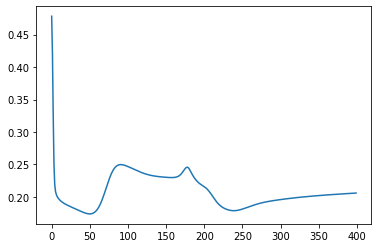

In [208]:
plt.plot(np.array(j_history))

In [209]:
o

array([-0.22346094, -0.31030504,  0.82708238, -0.18659254, -0.11874709,
       -0.96580006, -0.43844308, -0.5140163 , -0.91728865, -0.19237576,
       -0.86929982, -0.52355899, -0.72319279, -0.7780628 , -0.68666755,
       -0.79027053,  0.14225633, -0.70915896, -0.96655157, -0.71988091,
       -0.2539688 ,  0.52611768, -1.07355281,  0.80030267,  1.04112326,
       -0.54104683,  0.98334418, -0.38016249,  0.76888532, -0.90243722,
       -0.93335042, -0.01021359,  1.17773617,  0.97296311, -0.8258454 ,
        1.17798735,  0.805391  ,  1.1799079 , -0.68320566, -0.80537865,
        1.13119006, -0.28390816, -0.89492637,  0.10424474, -0.87081019,
       -0.01312701,  0.27916268, -0.74617458, -0.56248769, -0.88899822,
        0.57986908, -0.83380676, -0.87667742,  0.55781946, -0.89280623,
       -1.05648011, -0.75687236,  0.11833922,  0.56841893, -0.57965213,
       -0.06311234,  1.06145667,  0.16215103,  0.30213146, -0.73218882,
        0.04930812, -1.0914896 , -0.14821985,  0.60650527, -1.18

In [210]:
def mse_loss(y, pred):
    return np.mean((y - pred)**2)

def logistic_loss(y, pred):
    return np.mean(-y * np.log(pred) - (1-y)* np.log(1-pred))

def softmas_loss(y, pred):
    return - np.sum(y*np.log(pred))/y.shape[1]

In [211]:
def percRosen(x, y, alpha=1):
    w = np.zeros((x.shape[1]+1))
    x_ = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x_, y:
        y_ = np.sign(w.T@xi)
        ei = yi - y_
        w += (alpha * ei) * xi         
        y_out.append(y_)
    j = -np.sum(y*y_out)
    return w, np.array(y_out), j

def adeline(x,y, alpha=1):
    w = np.zeros(x.shape[1]+1)
    x = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x, y:
       y_ = w.T@xi
       ei = yi - y_       
       w += (alpha * ei) * xi
       y_out.append(np.sign(y_))
    j = np.sum((y-y_out)**2)/(2 * x.shape[0])
    return w, np.array(y_out), j

In [212]:
def percRosen(x, y, k=2, alpha=1):
    w = np.zeros((k,x.shape[1]+1))
    x_ = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x_, y:
        yk = []
        for ki in range(k):
            y_ = np.sign(w[ki].T@xi)
            ei = yi - y_
            w[ki] += (alpha * ei) * xi 
            yk.append(y_)
        y_out.append(yk)
    j = np.sum(np.max([0,-(y_out*y)],axis=1))
    return w, np.array(y_out), j

def adeline(x,y, k=2, alpha=1):
    w = np.zeros(k,x.shape[1]+1)
    x = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x, y:
        yk = []
        for ki in range(k):
            y_ = w[ki].T@xi
            ei = yi - y_       
            w[ki] += (alpha * ei) * xi
            yk.append(np.sign(y_))
        y_out.append(yk)
    j = np.sum(np.sum((y-y_out)**2,axis=1))/(2 * x.shape[0])
    return w, np.array(y_out), j

